## Notes:
This will require some more attention than just blindly copying into lightkurve
- What do we do if grids in frequency aren't evenly spaced?
- How will we carry the information around?
- Why isn't this star giving me a correct ACF?

I should absolutely:
- Copy-write from the ground up to gain better understanding of the functions as I write them.

- Build into the seismology package at first maybe?

In [18]:
from lightkurve import KeplerTargetPixelFile as ktpf
from lightkurve import KeplerLightCurveFile
import glob
sfile = glob.glob('mastDownload/K2/ktwo211416749-c05_lc/*.fits')
sfile
tpf = ktpf.from_fits(sfile[0])
lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers().correct(windows=10).remove_outliers()

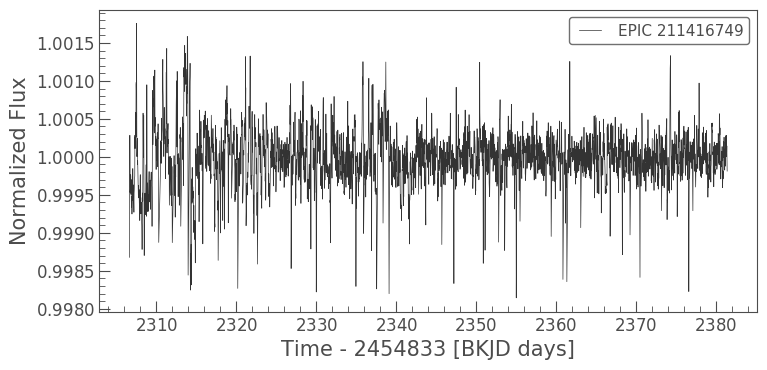

In [19]:
lc.plot()

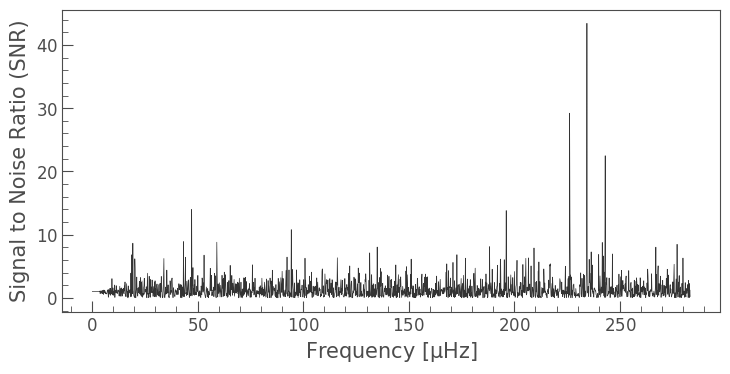

In [57]:
from astropy import units as u
pg = lc.periodogram(freq_unit = u.microhertz).remove_background(log_width=0.01)
pg.plot()

In [64]:
import numpy as np
power = pg.power.value
frequency = pg.frequency.value
frequency_spacing = pg.frequency_spacing.value
nyquist = pg.nyquist.value

In [65]:
pg.properties()

lightkurve.Periodogram properties:
      Attribute           Description       Units   
---------------------- ------------------ ----------
frequency_at_max_power           234.3549        uHz
     frequency_spacing             0.1547        uHz
             max_power            43.4234 ppm2 / uHz
               nyquist           283.2373        uHz
   period_at_max_power             0.0043    1 / uHz
             frequency      array (1831,)        uHz
                period      array (1831,)    1 / uHz
                 power      array (1831,) ppm2 / uHz
                 label <class 'NoneType'>           
                  meta     <class 'dict'>           
              targetid <class 'NoneType'>           


In [66]:
def ACF(power, frequency_spacing, numax):
    '''Function calcluates the ACF for a given numax.
    Paramters:
        numax (float64): numax of the expected envelope.

    Returns:
        ndarray: the ACF calculated for the given numax
        ndarray: the area of the power spectrum for which the ACF was calculated,
                multiplied by an appropriate hanning window.
    '''
    #Calculate the index FWHM for a given numax
    fwhm = int(np.floor(1.0 * 0.66 * numax**0.88 / frequency_spacing))
    fwhm -= fwhm % 2                                    # Make the FWHM value even (%2 = 0 if even, 1 if odd)
    x = int(numax / frequency_spacing)                  #Find the index value of numax
    s = np.hanning(len(power[x-fwhm:x+fwhm]))   #Define the hanning window for the evaluated frequency space
    C = power[x-fwhm:x+fwhm] * s                     #Multiply the evaluated SNR space by the hanning window
    result = np.correlate(C, C, mode='full')            #Correlated the resulting SNR space with itself
    return result[int(len(result)/2):], C               #Return the ACF and the evaluated SNR space

In [67]:
def mass_prior(numax, numax_sol=3050.0,
               dnu_sol=135.1, teff_sol=5777.0):
    ''' Mass scaling relation ...
    M/M' = (numax/numax')**3 (dnu/dnu')**-4 (teff/teff')**(3/2)
    So dnur**4 = numaxr**3 teffr**3/2 * Mr**-1*
    dnur = (nuamxr**3 * teffr**3/2 / Mr)**1/4
    dnu = (nuamxr**3 * teffr**3/2 / Mr)**1/4 * dnu'
    '''
    numaxr = numax / numax_sol
    teffr = np.array([3500, 5500]) / teff_sol
    Mr = np.array([10.0, 0.1])
    dnu = (numaxr**3 * teffr**1.5 / Mr)**0.25 * dnu_sol
    return dnu

def max_acfspace(frequency_spacing, numaxs):
    maxval = numaxs.max()
    fwhm = int(np.floor(1.0 * 0.66 * maxval**0.88 / frequency_spacing))
    fwhm -= fwhm % 2
    return int(2*fwhm)

In [81]:
#Note: This is not optimised for MS stars as well as RG. Make it nyquist based?
numaxs = np.exp(np.linspace(np.log(10),np.log(nyquist),200))

#Building the output arrays
data = np.zeros([len(numaxs), 4])
maxspace = max_acfspace(frequency_spacing, numaxs)
ACF_list = np.zeros((len(numaxs),maxspace))

#Calculating the ACF for each numax in our list
for idx, numax in enumerate(numaxs):
    acf, C = ACF(power, frequency_spacing, numax)    #Calculate the ACF for a given numax
    #Find lower and upper estimates on dnu for a range of relevant masses
    lower, upper = mass_prior(numax)
    #Append the ACF results for this numax and normalise them
    ACF_list[idx,:len(acf)] = acf/len(acf)
    max_bin = np.argmax(acf)    #Find the bin of maximum acf power for this numax
    dnu_est = max_bin * frequency_spacing   #Use the frequency value of this index as the Dnu estimate for this numax
    sum_acf = np.sum(ACF_list[idx,:len(acf)])
    #Store the acf value of maximum power, the corresponding numax, and correpsonding dnu estimate
    data[idx, :] = [acf[max_bin], numax, dnu_est, sum_acf]
    best_numax = data[np.argmax(data[:,0]), 1]     #The best numax is the numax that results in the highest ACF

array([2., 1., 1., ..., 0., 0., 0.])

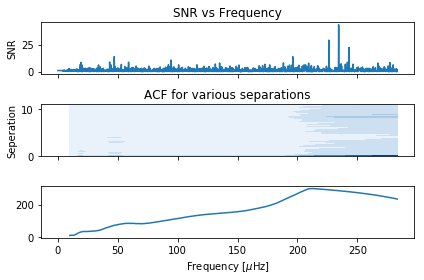

In [79]:
ylim = np.min(np.where(np.floor(np.median(ACF_list,axis=0)*2.) == 0.))
lag = np.linspace(0,ylim*frequency_spacing,ylim)

xlim = int(numaxs.max()/frequency_spacing)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,sharex=True)
ax[0].plot(frequency[:xlim],power[:xlim])
ax[0].set_ylabel(r'SNR')
ax[0].set_title(r'SNR vs Frequency')
ax[1].contourf(numaxs,lag,ACF_list[:,:ylim].T,cmap='Blues')
ax[1].set_title(r'ACF for various separations')
ax[1].set_ylabel(r'Seperation')
ax[2].plot(numaxs,np.sum(ACF_list,axis=1))
ax[2].set_xlabel(r'Frequency [$\mu$Hz]')
plt.tight_layout()

In [73]:
print(best_numax)
print(pg.frequency_at_max_power)

264.8264952750258
234.35490747184244 uHz
